# Parks and Public Transit Access in LA County

*Katrina Deloso & Ashley Yao*

**Introduction to our Research Question**

In this research project, we will analyze public transit access to 17 Regional Recreation Parks in LA County. We will examine which neighborhoods can access those recreation areas in a trip of 45 minutes or less of walking and public transit, and which forms of public transit are available to them. These 17 parks are the parks in LA County that each encompass over 100 acres and contain 3 or more active amenities, such as swimming pools or athletic fields.

We selected these parks because they draw users from across the county; sometimes drawing people from over 25 miles away. In this way, we’re using this definition of parks as a proxy for the most heavily used parks. Since users can live so far from these parks, they raise the question of how people get to the parks. Additionally, our research project has grown out of the LA Parks Needs Assessment project, which examined access to parks based on walking distance. That project inventoried over 3,000 parks and open spaces across the county, and divided them into four categories: Local Parks, Regional Recreation Parks, Regional Open Spaces, and Natural Areas. We selected the Regional Recreation Parks category for our analysis based on the reasoning above.

We will also be presenting census-tract level demographics on LA County; specifically, on race, income, and level of education. We want to examine whether there's a relationship between any of those demographics and access to parks.

Finally, we will aim to create a metric that measures the level of transit access to one or more of the regional parks, that we can assign to each census tract. This will likely be determined by measuring how many transit stops are available within the census tract that would take a rider to one or more of the 17 parks in less than 45 minutes total.

*Identification of Data Sources:*

* LA Metro: https://developer.metro.net/docs/gis-data/overview/
* LA County: County-wide Parks and Open Space: https://egis-lacounty.hub.arcgis.com/datasets/countywide-parks-and-open-space-public-hosted/
* LA County Park Needs: https://lacountyparkneeds.org/wp-content/uploads/2016/06/FinalReport.pdf
* Socrata
* Census Reporter
* https://www.ppic.org/content/pubs/cacounts/CC_206EBCC.pdf


*Importing Libraries*

In [1]:
# import libraries for: spatial data, plotting, network analysis, street network analysis, and basemaps

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as ctx

*Import Bus Data*

The bus stop data from LA Metro is imported, filtered, and analyzed to find drive sheds then walk sheds for Elysian Park.

In [2]:
bus = gpd.read_file('data/LineServingStops1219.shp')

*Line 4 Elysian Park*

Here we narrowed down the stops for Bus Route 2 and 4 which run adjacent to Elysian. Then turn the stop information into place values. Additionally we select one direction to reduce the number of isochrones needed. 

In [3]:
# narrowing down for Elysian route Lines 2 and 4 - these are the same along this section, so arbitrarily selected one.
busELY = bus.loc[bus['LINE']== 4]
busELY_sub = busELY[busELY['STOPNAME'].str.contains("SUNSET")]
busELY_subd = busELY_sub[busELY_sub['DIR_A2']=='E']
busELY_subd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17 entries, 2446 to 16288
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STOPNUM   17 non-null     int64   
 1   LINE      17 non-null     int64   
 2   DIR_A2    17 non-null     object  
 3   STOPNAME  17 non-null     object  
 4   LAT       17 non-null     float64 
 5   LONG      17 non-null     float64 
 6   geometry  17 non-null     geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 1.1+ KB


*Isochrone Map of Elysian Park LA Metro Route 2 Bus Stops*

Variables set and isogen function defined.

In [4]:
# variables set
# note to self: when you make drive isochrones for your buses make it about 15 minutes with 305 meters/min
network_type = 'walk'
trip_times = [15]
meters_per_minute = 75

In [5]:
#downloading street network
def isogen (gdf):
    global isochrones
    G = ox.graph.graph_from_point(center_point,dist = 2000, dist_type='bbox',
                              network_type='walk', simplify=True, retain_all=False, 
                              truncate_by_edge=False, clean_periphery=True, custom_filter=None)

#project to web mercator
    G = ox.project_graph(G,to_crs='epsg:3857')

#convert nodes and edges to geodata frames
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
   
    # establishing centroid
    minx,miny,maxx,maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    
    # selecting closest node
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    
    # isochrone building
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute
    
    iso_colors = ox.plot.get_colors(n=len(trip_times),
                                   cmap = 'plasma',
                                   start = 0,
                                   return_hex = True)
    trip_times.sort(reverse = True)
    time_color = list(zip(trip_times,iso_colors))
    time_color
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
    
    # legend
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G,center_node, radius = time, distance = 'time')
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time)+' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace = True)  
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns = ['time', 'geometry']
            

In [6]:
output = gpd.GeoDataFrame()
for index, row in busELY_subd.iterrows():
    center_point = row[4],row[5]
    isogen(busELY_subd)
    output = isochrones.append(output, ignore_index=True)

*Plot Setup with Isochrones*

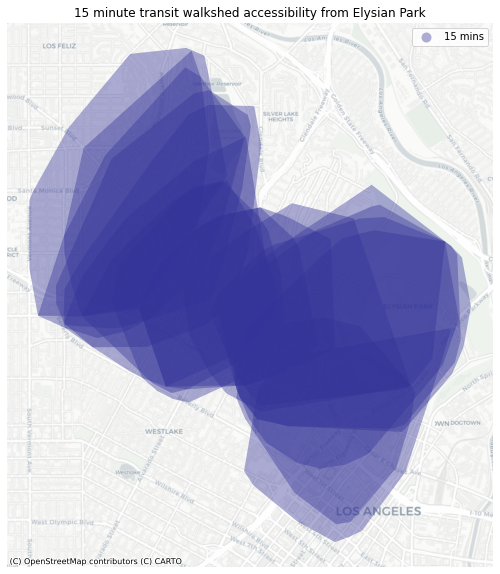

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

output.plot(alpha=0.4, ax=ax, column='time', cmap='terrain', legend=True, zorder=20)

ax.axis('off')
ax.set_title('15 minute transit walkshed accessibility from Elysian Park')
# Ashley assumed it would take 15 minutes to travel using bus exclusively along this one corridor

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

*List of Regional Recreation Parks*

1. Castiac Lake State Recreation Area, County of Los Angeles (Santa Clarita Transit)
2. Central Park, City of Santa Clarita (Santa Clarita Transit)
3. El Dorado Regional Park, Long Beach (Long Beach Transit)
4. Elysian Park, City of Los Angeles (analysis conducted above)
5. Ernest E. Debs Regional Park, City of Los Angeles
6. Frank Bonelli Regional Park, County of Los Angeles
7. Griffith Park, City of Los Angeles (analysis done by Katrina)
8. Hahamonga Watershed Park, City of Pasadena
9. Hansen Dam Park, City of Angeles
10. Heartwell Park, City of Long Beach
11. Ken Malloy Harbor Regional Park, City of Los Angeles
12. Kenneth Hahn State Recreation Area, County of Los Angeles
13. Peter F. Schabarum Regional County Park, County of Los Angeles
14. San Dimas Canyon Community Regional Park, County of Los Angeles
15. Santa Fe Dam Recreation Area, County of Los Angeles
16. Sepulveda Basin Recreation Area, City of Los Angeles
17. Whittier Narrows Recreation Area, County of Los Angeles

*Ernest E Debs Regional Park*

Analysis conducted for bus route 252 and 256. There is another route across the freeway, but we considered crossing a freeway to be inaccessible.

In [8]:
busEED1 = bus.loc[bus['LINE']== 252]
busEED1_sub = busEED1[busEED1['STOPNAME'].str.contains("MERCURY")]
busEED1_subd = busEED1_sub[busEED1_sub['DIR_A2']=='S']

In [9]:
busEED2 = bus.loc[bus['LINE']== 256]
busEED2_sub = busEED2[busEED2['STOPNAME'].str.contains("COLLIS")]
busEED2_subd = busEED1_sub[busEED1_sub['DIR_A2']=='N']

In [19]:
#still working on combinging these
#busEED = gpd.merge(busEED1_subd, busEED2_subd)
#busEED.head()

*Drive isochrone for Ernest E Debs Park*

In [11]:
# variables set
network_type = 'drive'
trip_times = [15] # made half estimated travel time in anticipation of slower buses
meters_per_minute = 305

In [12]:
#downloading street network
def isogen (gdf):
    global isochrones
    G = ox.graph.graph_from_point(center_point,dist = 2000, dist_type='bbox',
                              network_type='drive', simplify=True, retain_all=False, 
                              truncate_by_edge=False, clean_periphery=True, custom_filter=None)

#project to web mercator
    G = ox.project_graph(G,to_crs='epsg:3857')

#convert nodes and edges to geodata frames
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
   
    # establishing centroid
    minx,miny,maxx,maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    
    # selecting closest node
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    
    # isochrone building
    gdf_edges['drive_time'] = gdf_edges['length']/meters_per_minute
    
    iso_colors = ox.plot.get_colors(n=len(trip_times),
                                   cmap = 'plasma',
                                   start = 0,
                                   return_hex = True)
    trip_times.sort(reverse = True)
    time_color = list(zip(trip_times,iso_colors))
    time_color
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
    
    # legend
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G,center_node, radius = time, distance = 'time')
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time)+' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace = True)  
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns = ['time', 'geometry']
            

In [20]:
output1 = gpd.GeoDataFrame()
for index, row in busEED1_subd.iterrows():
    center_point = row[4],row[5]
    isogen(busEED1_subd)
    output1 = isochrones.append(output, ignore_index=True)

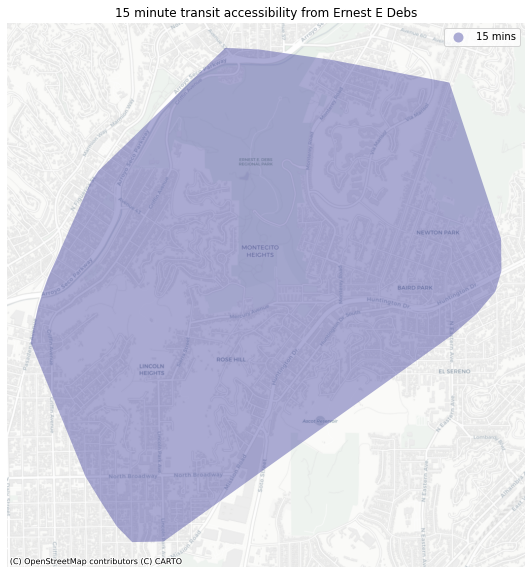

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

output1.plot(alpha=0.4, ax=ax, column='time', cmap='terrain', legend=True, zorder=20)

ax.axis('off')
ax.set_title('15 minute transit accessibility from Ernest E Debs')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [22]:
output2 = gpd.GeoDataFrame()
for index, row in busEED2_subd.iterrows():
    center_point = row[4],row[5]
    isogen(busEED2_subd)
    output2 = isochrones.append(output, ignore_index=True)

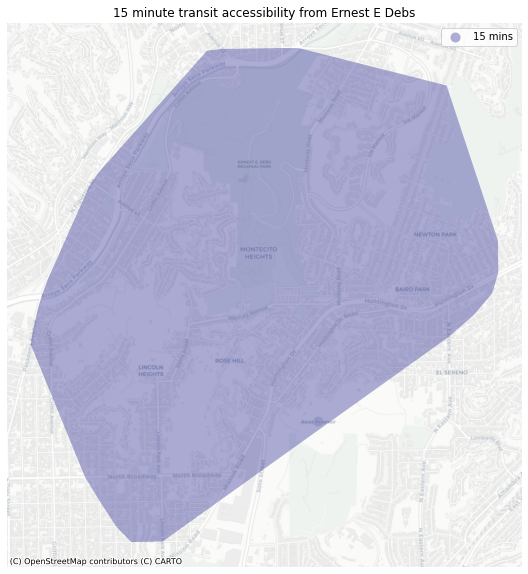

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

output2.plot(alpha=0.4, ax=ax, column='time', cmap='terrain', legend=True, zorder=20)

ax.axis('off')
ax.set_title('15 minute transit accessibility from Ernest E Debs')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

*Extrapolating which Bus Stops fall into this region*

(Haven't figured out how to do this yet... or a way of consolidating all of the bus data/routes needed)

# Combining with Census Data